# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

Aim and Objectives:
* Transform and analyse raw, tabular daily_temp_tsdf from a statistics website.
* Apply multiple machine-learning techniques to this daily_temp_tsdf.
* Investigate and document ethical and social implications.
* Create a data project and analysis related to real-life statistics.
* Deadline: 10th January 2024

Deliverables:
* 20 Pages (Maximum) Document in the IEEE Access format
* Project GitHub Pages Webpage
* 10 Page (Maximum) Generative AI Usage Journal

**IMPORTANT**: For dependencies, running and committing this notebooks, see: [README](./README.md)

## Problem: Energy Consumption vs Temperature vs Population (Malta-based)

Model Outcomes:
* Energy Demand Forecasting

# Data Preparation

## Dataset provenance
Electricity:
- [NSO Table 1. Electricity supply by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 2. Gross production of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 3. Electricity production from power plants by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 4. Estimated electricity production from renewable sources by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 5. Imports and exports of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 6. Electricity supply by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Table 8. GHG emissions from fuel combustion in power plants by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [Eurostat Net electricity generation by type of fuel - monthly data](https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_pem__custom_8232363/default/table?lang=en)

Climate:
- [Meteostat Temperature](https://dev.meteostat.net/sources.html)

Population:
- [Population Worldbank](https://data.worldbank.org/country/malta)

Indutrial Indices:
- [NSO Index of Industrial Production November 2018](https://nso.gov.mt/wp-content/uploads/News2019_003.pdf)
- [NSO Index of Industrial Production December 2018](https://nso.gov.mt/wp-content/uploads/News2019_019.pdf)
- [NSO Index of Industrial Production May 2020](https://nso.gov.mt/wp-content/uploads/News2020_109.pdf)
- [NSO Index of Industrial Production December 2020](https://nso.gov.mt/wp-content/uploads/News2021_020.pdf)
- [NSO Short Term Industrial Indicators Q4 2018](https://nso.gov.mt/wp-content/uploads/News2019_033.pdf)

## Preparation

* **Manual** edit of CSV to delete text, disclaimers and images from NSO. Output is a clean table.
* Removal of **features with >20% NaNs**. Too many gaps to interpolate.
* Drop data **> 3 standard deviations**.
* Resample to 22years from **2000 to 2022**.
* Normalize and reduce data. E.g. Mega Watts to Giga Watts, Minutes to Days, etc.
* Linear **interpolation of NaNs**.

In [11]:
import os
import re

import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

# Constants here
START_DATE = datetime(2000, 1, 1)
END_DATE = datetime(2022, 12, 31)

# All unprocessed CVs should go here.
RAW_DATA_PATH = "./raw_data"

# Base electricity datasets
ELECTRIC_MW_DS = [
    "Max_Demand_MW.csv",
    "Plant_Production_MWh.csv",
    "Imports_MWh.csv",
    "Renewables_Production_MWh.csv",
]
MEGA_TO_GIGA = 1000

all_data_df = None  # Main Dataset DF.
for filename in ELECTRIC_MW_DS:
    file_path = os.path.join(RAW_DATA_PATH, filename)
    # Convert mega to giga
    value_col = filename.split(".")[0].replace("_MW", "_GW")
    print(filename)

    df = pd.read_csv(file_path)

    # We will melt month (y-index) and year (x-index) to
    # create an index for each feature timeseries
    melted_df = df.melt(id_vars=["Month"], var_name="Year", value_name=value_col)
    melted_df[value_col] = melted_df[value_col].apply(
        # Clean - Values from string to scalar. Drop non-numeric characters (e.g. ,)
        lambda x: float(re.sub("[^0-9.]", "", str(x))) / MEGA_TO_GIGA
        if isinstance(x, (str))
        else x / MEGA_TO_GIGA
    )

    # set the index of Year-month, this will be for all timeseries
    melted_df["Date"] = pd.to_datetime(
        melted_df["Month"] + " " + melted_df["Year"], format="%B %Y"
    )
    melted_df.set_index("Date", inplace=True, drop=True)
    melted_df = melted_df.resample("MS").ffill()
    melted_df = melted_df[
        (melted_df.index >= START_DATE) & (melted_df.index <= END_DATE)
    ]

    result_df = melted_df[[value_col]]

    if all_data_df is None:
        all_data_df = result_df
    else:
        all_data_df = pd.concat([all_data_df, result_df], axis=1, ignore_index=False)


all_data_df.tail(3)

Max_Demand_MW.csv
Plant_Production_MWh.csv
Imports_MWh.csv
Renewables_Production_MWh.csv


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh
Date,,,,
2022-10-01,0.411,140.278,66.130,23.846
2022-11-01,0.411,182.610,13.054,16.788
2022-12-01,0.404,177.287,22.018,15.839


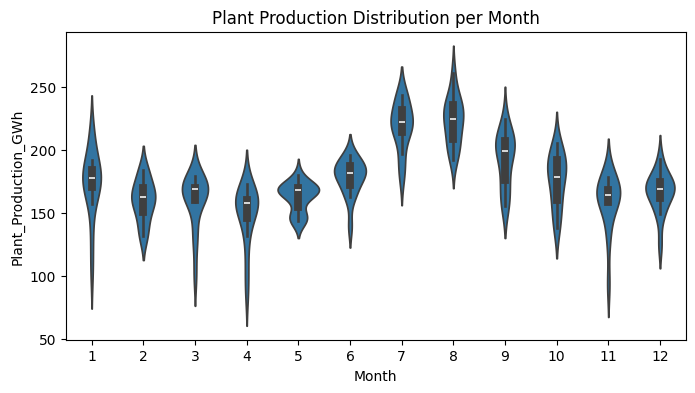

In [12]:
import seaborn as sns

sampling_subset = pd.DataFrame(all_data_df["Plant_Production_GWh"].copy())
sampling_subset["Month"] = sampling_subset.index.month

plt.figure(figsize=(8, 4))
sns.violinplot(
    x="Month",
    y="Plant_Production_GWh",
    data=sampling_subset,
)
plt.title("Plant Production Distribution per Month")
plt.show()

In [13]:
# the Datasets below need unique data cleaning
C02 = "PowerPlants_c02_KT.csv"

df = pd.read_csv(os.path.join(RAW_DATA_PATH, C02))
df["Year"] = pd.to_datetime(df["Year"], format="%Y")
df.set_index("Year", inplace=True, drop=True)
df = df.resample("MS").ffill()  # it misses Feb+

df.rename(columns={"CO2 kt": "powerplants_c02_kt"}, inplace=True)

# Create a copy of the subset and add columns for total and weights
sampling_subset = pd.DataFrame(all_data_df["Plant_Production_GWh"].copy())
sampling_subset = sampling_subset.resample("MS").ffill()

sampling_subset["total"] = sampling_subset.groupby(sampling_subset.index.year)[
    "Plant_Production_GWh"
].transform("sum")
sampling_subset["weights"] = (
    sampling_subset["Plant_Production_GWh"] / sampling_subset["total"]
)

df["powerplants_c02_kt"] = sampling_subset["weights"] * df["powerplants_c02_kt"]

df = df[(df.index >= START_DATE) & (df.index <= END_DATE)]

all_data_df = pd.concat(
    [all_data_df, df["powerplants_c02_kt"]], axis=1, ignore_index=False
)
all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt
2022-10-01,0.411,140.278,66.130,23.846,55.998585
2022-11-01,0.411,182.610,13.054,16.788,72.897400
2022-12-01,0.404,177.287,22.018,15.839,70.772474


In [14]:
POP_DS = "malta_population.csv"

pop_df = pd.read_csv(f"{RAW_DATA_PATH}/{POP_DS}")
pop_df = pop_df.T
pop_df.columns = ["Population"]

# Indexed on year only, resample to monthly. interpolate everything.
pop_df.index = pd.to_datetime(pop_df.index, format="%Y")
pop_df = pop_df.resample("M").mean()
pop_df = pop_df[(pop_df.index >= START_DATE) & (pop_df.index <= END_DATE)]

# resample puts it on the last day of the month!
pop_df.index = pop_df.index.to_period("M").to_timestamp("M") + pd.DateOffset(days=1)

# Population is missing the last months from the resample.
all_data_df = pd.concat([all_data_df, pop_df], axis=1, ignore_index=False)
all_data_df["Population"] = all_data_df["Population"].interpolate().ffill().bfill()

all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,Population
2022-10-01,0.411,140.278,66.130,23.846,55.998585,523417.0
2022-11-01,0.411,182.610,13.054,16.788,72.897400,523417.0
2022-12-01,0.404,177.287,22.018,15.839,70.772474,523417.0


In [15]:
from meteostat import Point, Daily, Monthly
import pandas as pd

# Create Point for Malta - specify latitude and longitude
malta = Point(35.8992, 14.5141)
temp_data_df = Monthly(malta, START_DATE, END_DATE)
temp_data_df = temp_data_df.fetch()
temp_data_df = temp_data_df[
    (temp_data_df.index >= START_DATE) & (temp_data_df.index <= END_DATE)
]

temp_data_df.index = pd.to_datetime(temp_data_df.index, format="%Y-%m-%d")
temp_data_df = temp_data_df.interpolate().bfill()

all_data_df = pd.concat([all_data_df, temp_data_df], axis=1, ignore_index=False)

all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,Population,tavg,tmin,tmax,prcp,wspd,pres,tsun
2022-10-01,0.411,140.278,66.130,23.846,55.998585,523417.0,21.6,18.2,25.3,15.8,11.2,1021.4,9060.0
2022-11-01,0.411,182.610,13.054,16.788,72.897400,523417.0,18.0,15.1,21.3,102.7,16.4,1016.1,9060.0
2022-12-01,0.404,177.287,22.018,15.839,70.772474,523417.0,16.3,13.2,19.4,5.4,13.9,1018.9,9060.0


In [16]:
# In case indices failed to align.
all_data_df = all_data_df.interpolate().ffill().bfill()
all_data_df.tail(5)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,Population,tavg,tmin,tmax,prcp,wspd,pres,tsun
2022-08-01,0.575,207.218,84.733,30.335,82.720845,523417.0,27.9,24.3,32.3,9.2,12.1,1012.7,9060.0
2022-09-01,0.531,175.458,76.455,25.780,70.042342,523417.0,25.9,22.9,29.4,65.2,14.1,1014.6,9060.0
2022-10-01,0.411,140.278,66.130,23.846,55.998585,523417.0,21.6,18.2,25.3,15.8,11.2,1021.4,9060.0
2022-11-01,0.411,182.610,13.054,16.788,72.897400,523417.0,18.0,15.1,21.3,102.7,16.4,1016.1,9060.0
2022-12-01,0.404,177.287,22.018,15.839,70.772474,523417.0,16.3,13.2,19.4,5.4,13.9,1018.9,9060.0


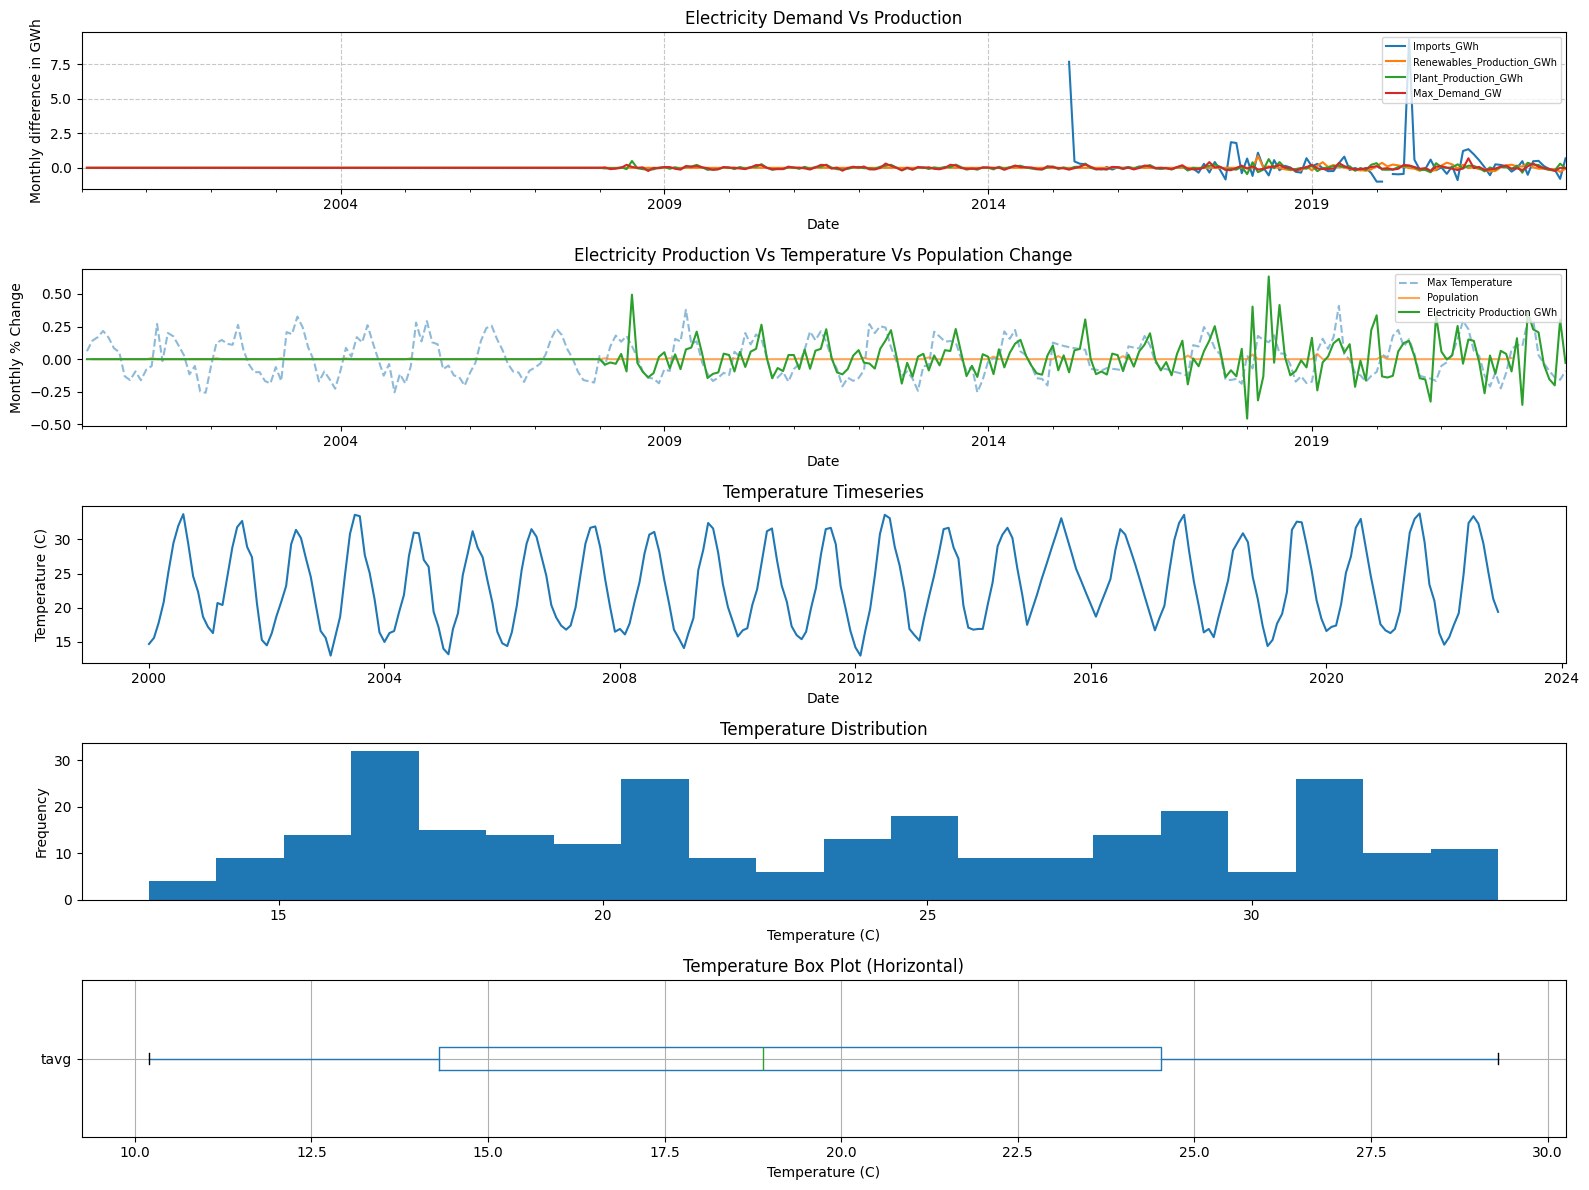

In [20]:
prod_cols = [
    "Imports_GWh",
    "Renewables_Production_GWh",
    "Plant_Production_GWh",
    "Max_Demand_GW",
]
temp_data = temp_data_df["tmax"]
fig, axes = plt.subplots(5, 1, figsize=(16, 12))
all_data_df[prod_cols].pct_change().ffill().plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Monthly difference in GWh")
axes[0].grid(axis="both", linestyle="--", alpha=0.7)
axes[0].set_title("Electricity Demand Vs Production")
axes[0].legend(fontsize=7, loc="upper right")
temp_data.pct_change().plot(

    kind="line", ax=axes[1], linestyle="--", alpha=0.5, label="Max Temperature"
)
pop_df.pct_change().plot(kind="line", ax=axes[1], alpha=0.7, label="Population")
all_data_df["Plant_Production_GWh"].pct_change().plot(
    kind="line", ax=axes[1], label="Electricity Production GWh"
)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Monthly % Change")
axes[1].set_title("Electricity Production Vs Temperature Vs Population Change")
axes[1].legend(fontsize=7, loc="upper right")
axes[2].plot(temp_data)
axes[2].set_ylabel("Temperature (C)")
axes[2].set_xlabel("Date")
axes[2].set_title("Temperature Timeseries")
axes[3].hist(temp_data, bins=20)
axes[3].set_xlabel("Temperature (C)")
axes[3].set_ylabel("Frequency")
axes[3].set_title("Temperature Distribution")
all_data_df.boxplot(column="tavg", vert=False)
axes[4].set_title("Temperature Box Plot (Horizontal)")
axes[4].set_xlabel("Temperature (C)")
plt.tight_layout()
plt.show()

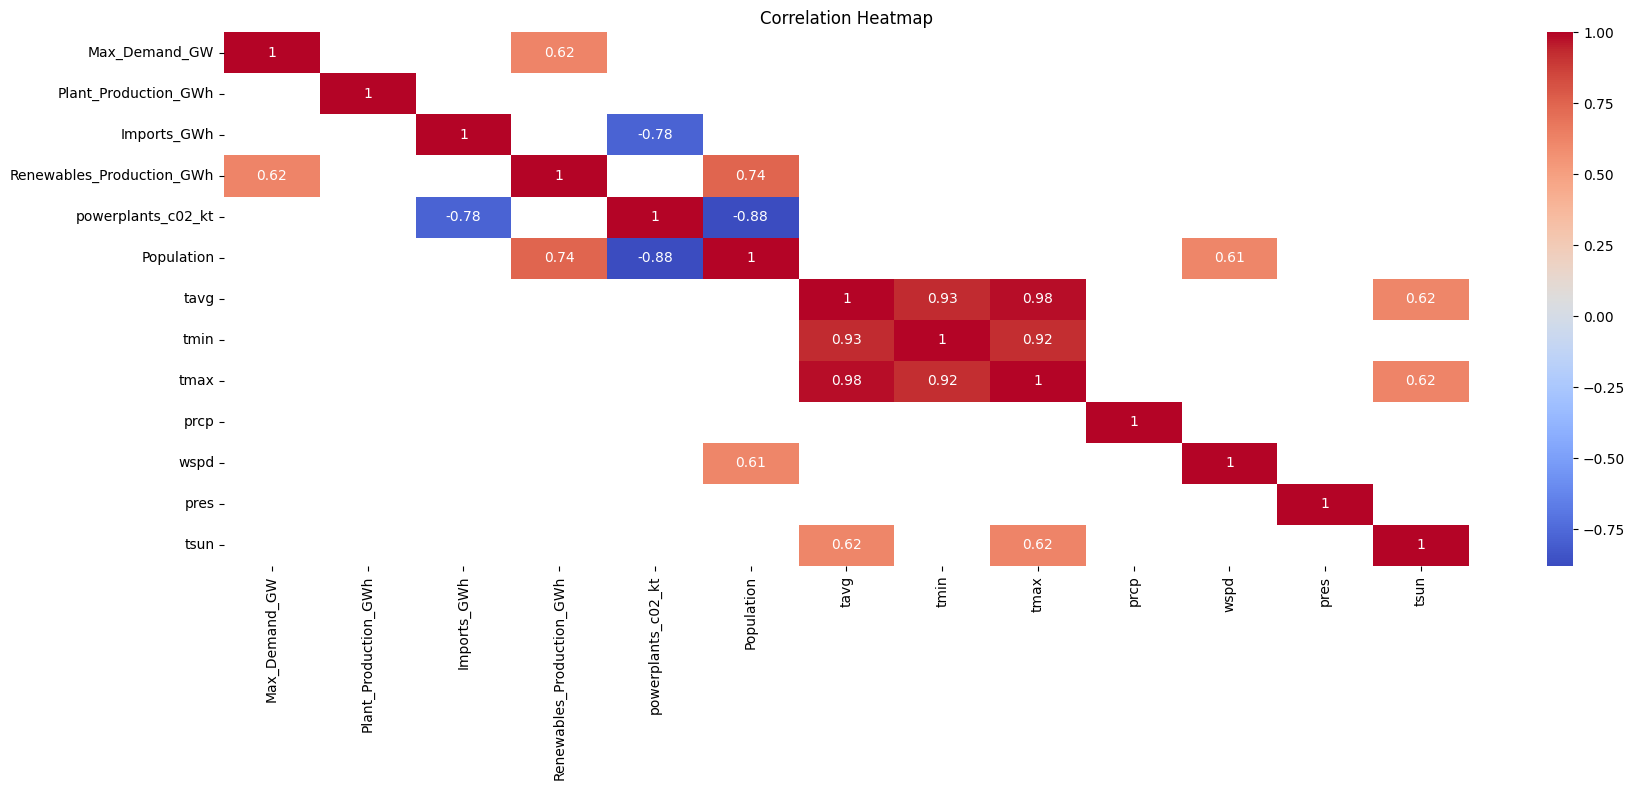

In [18]:
plt.figure(figsize=(18, 8))

CR_THRESHOLD = 0.6

corr_matrix = all_data_df.corr()
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", mask=(np.abs(corr_matrix) <= CR_THRESHOLD)
)
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, test_validate_df = train_test_split(
    all_data_df, test_size=0.3, random_state=42
)
test_df, validate_df = train_test_split(
    test_validate_df, test_size=0.5, random_state=42
)

train_df.to_csv("./data/train_data.csv", index=True)
test_df.to_csv("./data/test_data.csv", index=True)
validate_df.to_csv("./data/validate_data.csv", index=True)